In [3]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [4]:
# Packages
from numpy import array, hstack
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Flatten, TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Text(0, 0.5, 'Prices ($)')

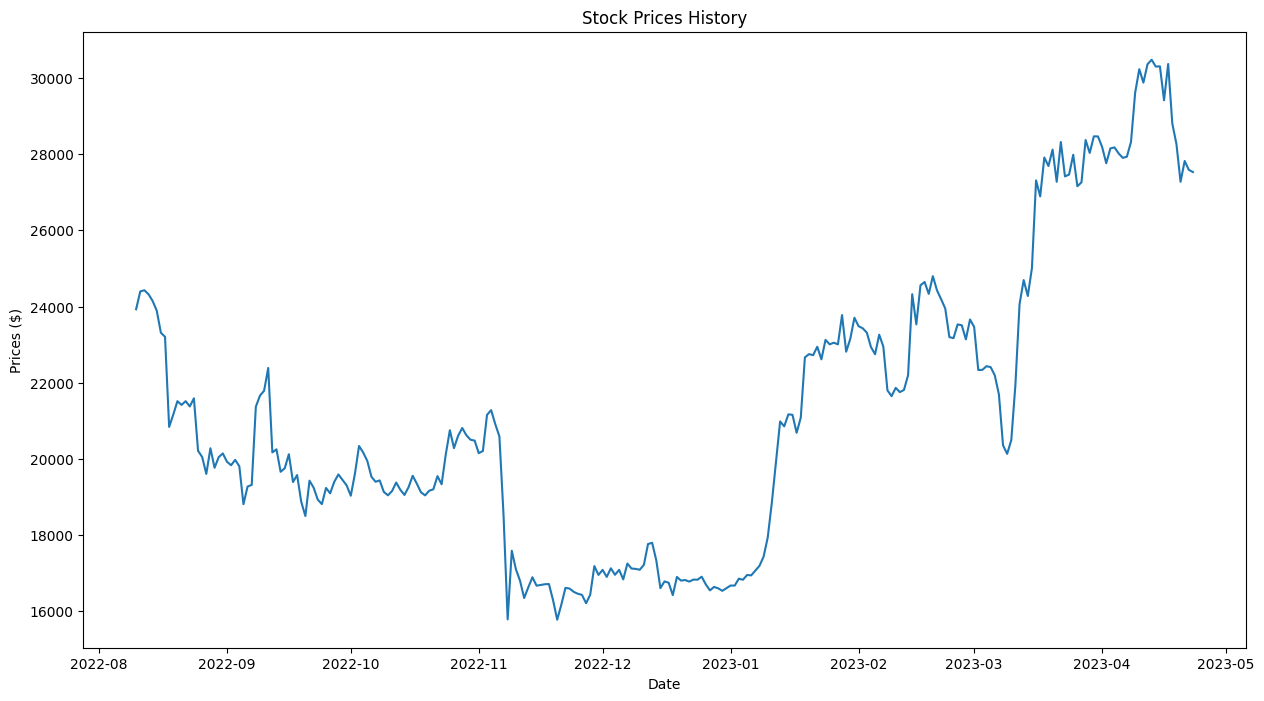

In [5]:
stock_data = pd.read_csv(r"/content/drive/MyDrive/Bitcoin.csv", index_col='Date', parse_dates=True)

plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

Text(0, 0.5, 'Prices ($)')

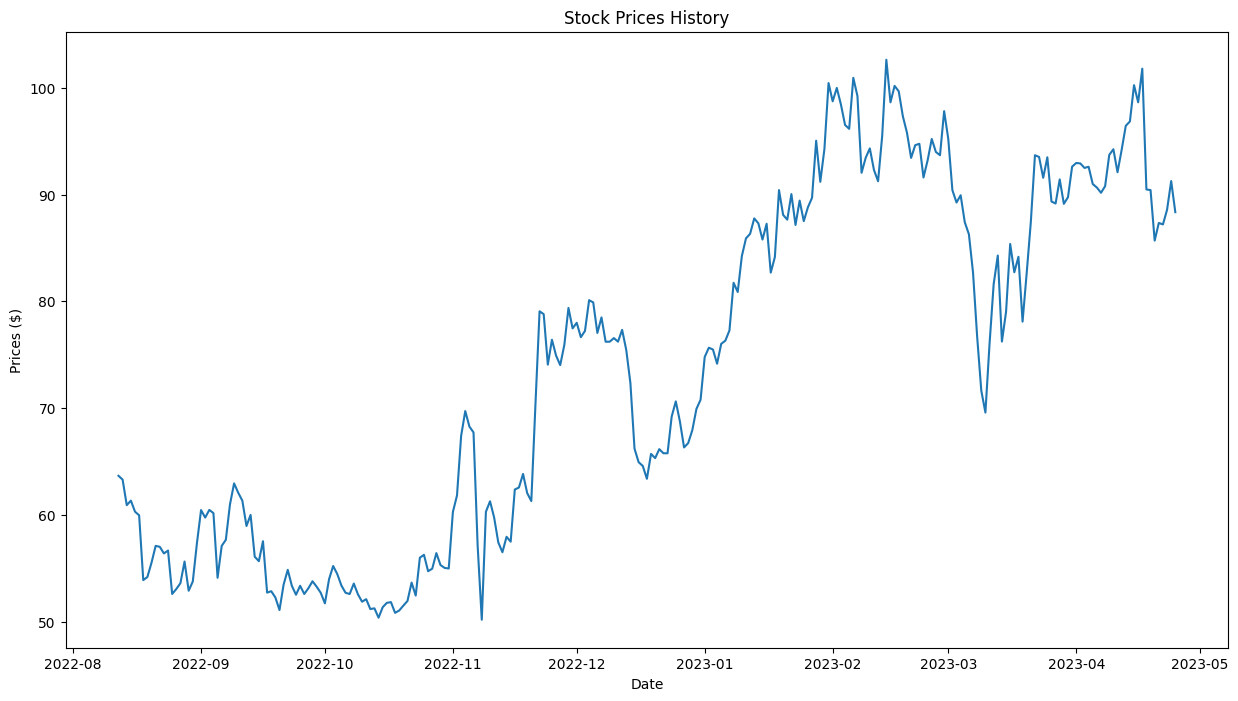

In [6]:
stock_data = pd.read_csv(r"/content/drive/MyDrive/Litecon.csv", index_col='Date', parse_dates=True)

plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

Text(0, 0.5, 'Prices ($)')

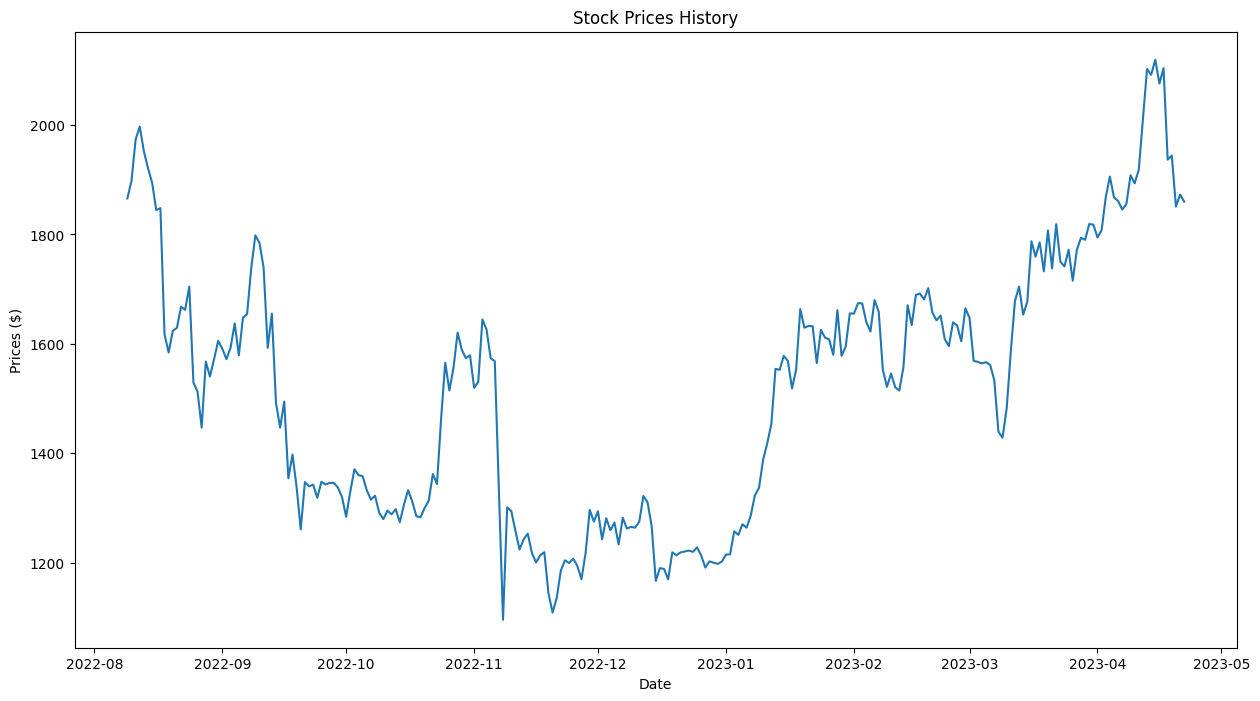

In [7]:
stock_data = pd.read_csv(r"/content/drive/MyDrive/Ethereum.csv", index_col='Date', parse_dates=True)

plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [8]:
stock_data.head(1)

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2023-04-22,1872.457,1877.083,1839.502,1860.099,1.430000e+10,2.240000e+11


## daily_score

In [9]:
daily_score = pd.read_csv('/content/drive/MyDrive/time_serie_Twitter_sentiment.csv',index_col='Date')
daily_score.index = pd.to_datetime(daily_score.index)
daily_score

,Unnamed: 0,weighted_positive_score,weighted_neutral_score,weighted_negative_score,total,is_missing_value
Date,,,,,,
2023-04-23,0,0.299347,0.602728,0.097925,7705495,0
2023-04-22,1,0.358841,0.565735,0.075424,16580043,0
2023-04-21,2,0.378946,0.395909,0.225145,12031397,0
2023-04-20,3,0.509324,0.390879,0.099797,48100078,0
2023-04-19,4,0.571424,0.277535,0.151041,31872015,0
...,...,...,...,...,...,...
2022-08-14,252,0.290828,0.450175,0.237421,72051516,1
2022-08-13,253,0.290828,0.450175,0.237421,72051516,1
2022-08-12,254,0.290828,0.450175,0.237421,72051516,1


In [10]:
# Split Function
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [11]:
def mape(y, y_hat):
    return np.mean(np.abs((y - y_hat)/y)*100)

In [12]:
sequences = data = pd.DataFrame({'log_return_open':[2**i for i in range(1,5)],
                     'log_return_close':[3**i for i in range(1,5)],
                     'log_volume':[5**i for i in range(1,5)] })
sequences

,log_return_open,log_return_close,log_volume
0,2,3,5
1,4,9,25
2,8,27,125
3,16,81,625


In [13]:
n_steps = 3
n_seq = 2
n_features = int((len(sequences.columns)-1)/2)
X,y= split_sequences(np.array(sequences), n_steps)

X

array([[[ 2,  3],
        [ 4,  9],
        [ 8, 27]],

       [[ 4,  9],
        [ 8, 27],
        [16, 81]]])

In [14]:
def reverse(log_return,initial_value):
    return np.exp(np.cumsum(log_return))*initial_value

# CNN LSTM

In [15]:
log_return_open = np.diff(np.log(stock_data['Open']))
log_return_close = np.diff(np.log(stock_data['Close']))
log_volume = np.log(stock_data['Volume'])

# Prepare the data

data = pd.DataFrame({'log_return_open t-1':log_return_open,
                     'log_volume t-1':log_volume[:-1],
                     'log_return_close t-1' : log_return_close,
                     
                     'log_return_close t':log_return_close})


data['log_return_open t-1'] = data['log_return_open t-1'].shift(1)
data['log_return_close t-1'] = data['log_return_close t-1'].shift(1)
data['log_volume t-1'] = data['log_volume t-1'].shift(1)
data = data[1:]
dataset = np.array(data)
dataset = dataset.reshape((len(dataset), len(data.columns)))

In [16]:
data

,log_return_open t-1,log_volume t-1,log_return_close t-1,log_return_close t
Date,,,,
2023-04-21,-0.011933,23.383525,0.006864,-0.011811
2023-04-20,0.048498,23.753400,-0.011811,0.049224
2023-04-19,-0.002710,24.051893,0.049224,-0.003877
2023-04-18,0.082693,24.204506,-0.003877,0.082847
2023-04-17,-0.013407,24.094004,0.082847,-0.013411
...,...,...,...,...
2022-08-14,0.017106,23.909618,0.014018,0.015973
2022-08-13,0.024026,23.981362,0.015973,0.022797
2022-08-12,-0.011699,23.678176,0.022797,-0.011890


In [17]:
# Set parameters
n_steps = 3
n_seq = 1
n_features = int((len(data.columns)-1))

# Define Model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [19]:
from tqdm import tqdm
# 3 - Forecast
end_training_day = 30
y_actual = dataset[end_training_day:,len(data.columns)-1:] # Real values for accuracy measurement
finalresults=pd.DataFrame()

# Increasing window cross-validation 
for k in tqdm(range(10)):
    result=pd.DataFrame()
    for w in range(end_training_day, len(dataset), 1):
        train=dataset[:w]
        X, y = split_sequences(train, n_steps)
        X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
        model.fit(X, y, epochs=10, verbose=0)
        
        test_X,y_test=split_sequences(dataset[w-n_steps+1:w+1],n_steps)
        if y_test[0]!=dataset[w,len(data.columns)-1:][0]:
            break
    
        for test_i in test_X:
            aaa = test_i.reshape((1, n_seq, n_steps, n_features))
            yhat = pd.DataFrame(model.predict(aaa, verbose=0))
            result = pd.concat((result, yhat))
    finalresults = pd.concat((finalresults, result), axis=1)

y_mean=pd.DataFrame(finalresults.mean(axis=1))
print(sqrt(mean_squared_error(y_actual, y_mean)))
print(mape(y_actual,y_mean))

100%|██████████| 10/10 [16:35<00:00, 99.57s/it]

0.0029739988818472626
0    27.504321
dtype: float64



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


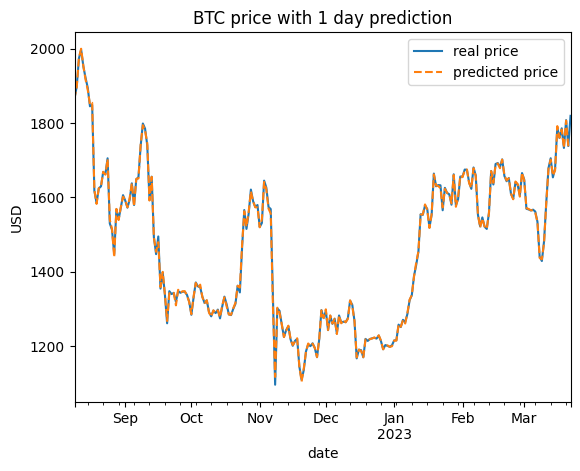

In [21]:
real_price = stock_data['Close'][end_training_day+1:].values

t_price = np.array([])
for w in range(0,len(y_mean), 1):
    t_price = np.concatenate([t_price,reverse(y_mean.values.flatten()[w:w+1], real_price[w])]) ## Recompute the price from log return 
    
stock_data['Close'][end_training_day+1:].plot(label='real price')

pd.Series(t_price, index=stock_data['Close'][end_training_day+2:].index).plot(label='predicted price',linestyle='dashed')
    
# plt.plot(real_price)
# plt.plot(t_price,label='predicted price',linestyle='dashed')
plt.legend()
plt.xlabel('date')
plt.ylabel('USD')
plt.title('BTC price with 1 day prediction')
plt.savefig('btc prediction without sentiment variables.png',dpi=500)

In [22]:
df_pred = pd.DataFrame(t_price)
df_pred.index = stock_data['Close'][end_training_day+2:].index
df_pred.columns = ["Predicted_price_without_sentiment"]
df_pred.head()

,Predicted_price_without_sentiment
Date,
2023-03-21,1736.997803
2023-03-20,1805.974365
2023-03-19,1733.039185
2023-03-18,1781.986328
2023-03-17,1760.049683


In [23]:
df_pred.to_csv('predictions_without_sentiment_BTC.csv')

# CNN LSTM sentimental

In [30]:
log_return_open = np.diff(np.log(stock_data['Open']))
log_return_close = np.diff(np.log(stock_data['Close']))
positive_score = daily_score['weighted_positive_score'].values[:-2]
negative_score = daily_score['weighted_negative_score'].values[:-2]
log_volume = np.log(stock_data['Volume'])

# Check the length of each array
print(len(log_return_open))
print(len(log_return_close))
print(len(positive_score))
print(len(negative_score))
print(len(log_volume))

# Prepare the data
min_len = min(len(log_return_open), len(log_return_close), len(positive_score), len(negative_score), len(log_volume))
data = pd.DataFrame({
    'log_return_open t-1': log_return_open[:min_len],
    'log_volume t-1': log_volume[:-1][:min_len],
    'log_return_close t-1': log_return_close[:min_len],
    'positive_score': positive_score,
    'negative_score': negative_score,
    'log_return_close t': log_return_close[1:min_len+1]
})

data['log_return_open t-1'] = data['log_return_open t-1'].shift(1)
data['log_return_close t-1'] = data['log_return_close t-1'].shift(1)
data['log_volume t-1'] = data['log_volume t-1'].shift(1)

data = data.dropna()
dataset = np.array(data)
dataset = dataset.reshape((len(dataset), len(data.columns)))


256
256
255
255
257


In [25]:
# Set parameters
n_steps = 3
n_seq = 1
n_features = int((len(data.columns)-1))

# Define Model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [26]:
# 3 - Forecast
end_training_day = 30
y_actual = dataset[end_training_day:,len(data.columns)-1:] # Real values for accuracy measurement
finalresults=pd.DataFrame()

# Increasing window cross-validation 
for k in tqdm(range(10)):
    result=pd.DataFrame()
    for w in range(end_training_day, len(dataset), 1):
        train=dataset[:w]
        X, y = split_sequences(train, n_steps)
        X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
        model.fit(X, y, epochs=10, verbose=0)
        
        test_X,y_test=split_sequences(dataset[w-n_steps+1:w+1],n_steps)
        if y_test[0]!=dataset[w,len(data.columns)-1:][0]:
            break
    
        for test_i in test_X:
            aaa = test_i.reshape((1, n_seq, n_steps, n_features))
            yhat = pd.DataFrame(model.predict(aaa, verbose=0))
            result=pd.concat((result, yhat))
    finalresults=pd.concat((finalresults, result), axis=1)

y_mean_sent=pd.DataFrame(finalresults.mean(axis=1))
print(sqrt(mean_squared_error(y_actual, y_mean_sent)))
print(mape(y_actual,y_mean_sent))

100%|██████████| 10/10 [18:17<00:00, 109.78s/it]

0.003712724061749958
0    28.067924
dtype: float64



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


## Visualisation

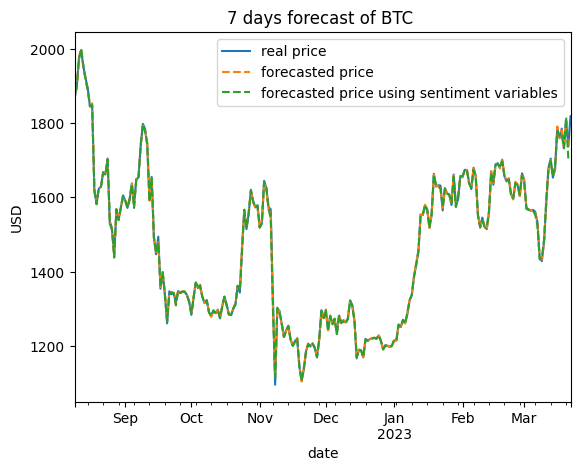

In [27]:
t_price = np.array([])
for w in range(0,len(y_mean), 1):
    t_price = np.concatenate([t_price,reverse(y_mean.values.flatten()[w:w+1], real_price[w])])
    
t_price_sent = np.array([])
for w in range(0,len(y_mean_sent), 1):
    t_price_sent = np.concatenate([t_price_sent,reverse(y_mean_sent.values.flatten()[w:w+1], real_price[w])])
    
stock_data['Close'][end_training_day+1:].plot(label='real price')

pd.Series(t_price, index=stock_data['Close'][end_training_day+2:].index).plot(label='forecasted price',linestyle='dashed')

pd.Series(t_price_sent, index=stock_data['Close'][end_training_day+2:].index).plot(label='forecasted price using sentiment variables',linestyle='dashed')
    
# plt.plot(real_price)
# plt.plot(t_price,label='predicted price',linestyle='dashed')
plt.legend()
plt.xlabel('date')
plt.ylabel('USD')
plt.title('7 days forecast of BTC ')
plt.savefig('btc prediction with sentiment variables and without.png',dpi=500)

In [28]:
df_pred_2 = pd.DataFrame(t_price_sent)
df_pred_2.index = stock_data['Close'][end_training_day+2:].index
df_pred_2.columns = ["Predicted_price_with_sentiment"]
df_pred_2.head()

,Predicted_price_with_sentiment
Date,
2023-03-21,1704.910278
2023-03-20,1816.074829
2023-03-19,1732.362915
2023-03-18,1770.789917
2023-03-17,1765.712891


In [29]:
df_pred_2.to_csv('predictions_with_sentiment_BTC.csv')